# Instructions


* For model checkpointing to work, I had to fix a bug in keras. This fix can be found in my branch of keras:
```
git clone https://github.com/hfinger/keras.git
cd keras
python setup.py develop
```

* To run this as a presentation you need to install the RISE jupyter extension. I modified some slide stylings and fixed a bug with vertical centering of slides im my branch of RISE:
```
git clone https://github.com/hfinger/RISE.git
cd RISE
python setup.py install
```


In [1]:
# this is to setup the presentation resolution to match to the projector. 
# You need to restart jupyter after executing this.
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'center': False,
 'height': 768,
 'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'serif',
 'transition': 'zoom',
 'width': 1024}

In [2]:
%matplotlib inline
%load_ext autoreload
%aimport statefarm
%autoreload 1

import matplotlib
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import theano
import theano.tensor as T
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.visualize_util import model_to_dot
from statefarm import Statefarm
rng = np.random

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 4007)


<br><br><br><br><br><br><br><br><br><br>

# <p style="text-align: center;">Deep Learning with Theano and Keras</p>
<p style="text-align: center;">Holger Finger</p>
<p style="text-align: center;">9.5.2016</p>

<br><br><br><br><br><br><br><br><br><br>

## <p style="text-align: center;">Outline</p>

1. Theano Tutorial

2. Application to Distracted Driver Detection using Keras

<br><br><br><br><br><br>
# <p style="text-align: center;">What is Theano?</p>

> <a href="http://deeplearning.net/software/theano/">Theano</a> is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently.

<br>
* Tight integration with NumPy

* Transparent use of a GPU

* Efficient symbolic differentiation

### <p style="text-align: center;">Generate some sample data</p>
$$y=x \cdot slope + offset$$
<p style="text-align: center;">and add some Gaussian noise</p>

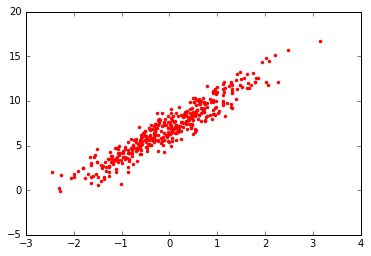

In [3]:
N = 400
slope = 3
offset = 7
data_x = rng.randn(N,)
data_y = data_x * slope + offset + rng.randn(N,)
plt.plot(data_x, data_y, 'r.');

## <p style="text-align: center;">Defining a Model in Theano to learn from data</p>

Define Theano symbolic variables:

In [4]:
x = theano.tensor.vector("x", dtype='float64')
y = theano.tensor.vector("y", dtype='float64')
w = theano.shared(0., name="w")
b = theano.shared(0., name="b")

Construct Theano expression graphs:

In [5]:
pred = x * w + b
squared_err = ((pred - y) ** 2)
loss = squared_err.mean()
gw, gb = T.grad(loss, [w, b])

Compile Theano functions:

In [6]:
train = theano.function(inputs=[x,y], 
            outputs=[pred, squared_err], 
            updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))
predict = theano.function(inputs=[x], outputs=pred)

## <p style="text-align: center;">Training the model</p>

* Run this multiple times to see how the model (blue line) improves with each iteration:

w = 0.00
b = 0.00


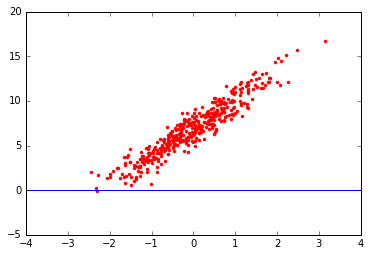

In [7]:
print("w = %.2f" % w.get_value())
print("b = %.2f" % b.get_value())

plt.plot(data_x, data_y, 'r.');
plt.plot(np.linspace(-4,4,20), predict(np.linspace(-4,4,20)), 'b-');

train(data_x, data_y);

# <p style="text-align: center;">Theano Expression Graphs</p>

In [8]:
theano.printing.pydotprint(
        pred, 
        outfile='images/graph_pred.png',
        format='png', var_with_name_simple=True)
theano.printing.pydotprint(
        loss, 
        outfile='images/graph_loss.png',
        format='png', var_with_name_simple=True)
theano.printing.pydotprint(
        gw, 
        outfile='images/graph_gw.png',
        format='png', var_with_name_simple=True)

The output file is available at images/graph_pred.png
The output file is available at images/graph_loss.png
The output file is available at images/graph_gw.png


# <p style="text-align: center;">Theano Under the Hood</p>
$$pred_i = x_i \cdot w + b$$
![graph pred](images/graph_pred.png)

### <p style="text-align: center;">Graph of Squared Error Loss: $loss = \frac{1}{N} \cdot \sum_{i=1}^N{ (pred_i - y_i) ^ 2 }$</p>
![graph loss](images/graph_loss.png)

### <p style="text-align: center;">Graph of Weight Gradient: $\frac{\partial loss}{\partial w} = ...$</p>
![graph gw](images/graph_gw.png)

<br><br><br><br><br><br><br><br>
# <p style="text-align: center;">Part 2: Application:</p>
# <p style="text-align: center;">Distracted Driver Detection</p>

<br><br><br><br>
## <p style="text-align: center;">Kaggle Competition: </p>
<br>
### <p style="text-align: center;">State Farm Distracted Driver Detection</p>

<br>

* Can 2D dashboard cameras automatically detect drivers engaging in distracted behaviors?

<br>

* Sponsored by State Farm (US based insurance company)

<br>

* Competition started on 5th April and ends on 1st August

### <p style="text-align: center;">Data available from Statefarm</p>

* 22424 training images with class labels

* 79726 test images without class labels

<table style="border: none;">
<tr style="border: none;">
<td style="border: none; text-align:center; font-size: 50%">normal driving</td>
<td style="border: none; text-align:center; font-size: 50%">texting - right</td>
<td style="border: none; text-align:center; font-size: 50%">talking on the phone - right</td>
<td style="border: none; text-align:center; font-size: 50%">texting - left</td>
<td style="border: none; text-align:center; font-size: 50%">talking on the phone - left</td>
</tr>
<tr style="border: none;">
<td style="border: none;"><img src="images/c0.jpg"></td>
<td style="border: none;"><img src="images/c1.jpg"></td>
<td style="border: none;"><img src="images/c2.jpg"></td>
<td style="border: none;"><img src="images/c3.jpg"></td>
<td style="border: none;"><img src="images/c4.jpg"></td>
</tr>
<tr style="border: none;">
<td style="border: none; text-align:center; font-size: 50%">operating the radio</td>
<td style="border: none; text-align:center; font-size: 50%">drinking</td>
<td style="border: none; text-align:center; font-size: 50%">reaching behind</td>
<td style="border: none; text-align:center; font-size: 50%">hair and makeup</td>
<td style="border: none; text-align:center; font-size: 50%">talking to passenger</td>
</tr>
<tr style="border: none;">
<td style="border: none;"><img src="images/c5.jpg"></td>
<td style="border: none;"><img src="images/c6.jpg"></td>
<td style="border: none;"><img src="images/c7.jpg"></td>
<td style="border: none;"><img src="images/c8.jpg"></td>
<td style="border: none;"><img src="images/c9.jpg"></td>
</tr>
</table>

### <p style="text-align: center;">Evaluation</p>

* Assign probabilities $p_{ij}$ that image $i$ belongs to class $j$

* The submissions are rated according to multi-class cross-entropy loss:
$$logloss = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij} \cdot  log(p_{ij})$$

* $y_{ij}$ is 1 if observation i belongs to class j and 0 otherwise

* $p_{ij}$ is bounded between $10^{-15}$ and $1-10^{-15}$ and normalized to sum to 1 per image

### <p style="text-align: center;">Introduction to Keras</p>
* What is Keras?
> <a href="http://keras.io">Keras</a> is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either <a href="https://www.tensorflow.org">TensorFlow</a> or <a href="http://deeplearning.net/software/theano">Theano</a>.
* Defining a Keras model:

In [9]:
model = Sequential()
model.add(Flatten(input_shape=(1, 24, 32)))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
flatten_1 (Flatten)                (None, 768)         0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                    (None, 20)          15380       flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                    (None, 10)          210         dense_1[0][0]                    
Total params: 15590
____________________________________________________________________________________________________


In [11]:
keras.utils.visualize_util.plot(model, to_file='images/keras_model.png')

### <p style="text-align: center;">Keras Model Graph:</p>
![graph keras](images/keras_model.png)

In [12]:
theano.printing.pydotprint(
        model.output, 
        outfile='images/graph_model.png',
        format='png', var_with_name_simple=True)

The output file is available at images/graph_model.png


### <p style="text-align: center;">Theano Graph generated by the Keras model:</p>
![graph model](images/graph_model.png)

## <p style="text-align: center;">Some preparations to train the model:</p>

<font size="5">We define the specific loss function that is used to grade the submissions:</font>

In [13]:
def log_loss_objective(y_true, y_pred):
    y_pred = T.clip(y_pred, 1.0e-15, 1.0 - 1.0e-15)
    y_pred /= y_pred.sum(axis=-1, keepdims=True)
    cce = T.nnet.categorical_crossentropy(y_pred, y_true)
    return cce

<font size="5">Compile the model and use standard gradient descent (SGD) as optimizer:</font>

In [14]:
model.compile(loss=log_loss_objective, 
              optimizer=SGD(lr=0.01, 
                            decay=0, 
                            momentum=0, 
                            nesterov=False))

<font size="5">Load training data:</font>

In [15]:
# load statefarm data:
use_cache = 1
path_data = "/net/store/ni/projects/deeplearning/statefarm"
path_cache = "/net/store/ni/projects/deeplearning/statefarm/cache"

statefarm = Statefarm(use_cache, path_data, path_cache)

# color type: 1 - grey, 3 - rgb
color_type_global = 1

# input image dimensions
img_rows, img_cols = 24, 32

train_data, train_target, d_ids, unique_drivers = statefarm.read_and_normalize_train_data(
    img_rows, img_cols, color_type_global)
test_data, test_id = statefarm.read_and_normalize_test_data(img_rows, img_cols, color_type_global)

yfull_train = dict()
yfull_test = []
unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p021', 'p022', 'p024',
                 'p026', 'p035', 'p039', 'p041', 'p045', 'p047', 'p049',
                 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072']
unique_list_valid = ['p081', 'p042']
unique_list_test = ['p075', 'p016']

X_train, Y_train, train_index = statefarm.copy_selected_drivers(train_data, train_target, d_ids, unique_list_train)
X_valid, Y_valid, valid_index = statefarm.copy_selected_drivers(train_data, train_target, d_ids, unique_list_valid)
X_test, Y_test, test_index = statefarm.copy_selected_drivers(train_data, train_target, d_ids, unique_list_test)

<font size="5">Save weights during training and stop training if validation loss increases:</font>

In [16]:
# Define training callbacks
now = datetime.datetime.now()
checkpoint_filename = 'checkpoint_' + str(now.strftime("%Y-%m-%d-%H-%M-%S")) + '.hdf5'
checkpoint_path = os.path.join('checkpoints', checkpoint_filename)
checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, 
                                                      save_best_only=True, mode='min')

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

## <p style="text-align: center;">Train the model and print the log loss</p>

In [17]:
print('log_loss before training: %.2f' % model.evaluate(X_valid, Y_valid, verbose=0))

history = model.fit(X_train, Y_train, batch_size=32, 
                    nb_epoch=100, verbose=0, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=[checkpoint_callback, early_stopping_cb])

model.load_weights(checkpoint_path)
print('log_loss of validation set: %.2f' % model.evaluate(X_valid, Y_valid, verbose=0))
print('log_loss of test set: %.2f' % model.evaluate(X_test, Y_test, verbose=0))

log_loss before training: 2.38
log_loss of validation set: 1.66
log_loss of test set: 1.99


* Log loss of the uniform predictor is $2.303$
* Log loss of the optimal predictor is $9.99\cdot 10^{-16} \approx 0$

## <p style="text-align: center;">Problems with overfitting</p>
* we are overfitting when the loss on the validation set increases

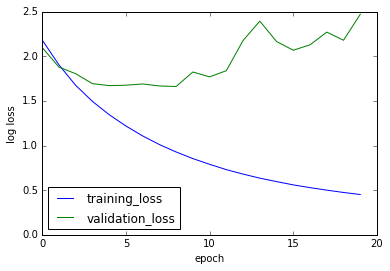

In [18]:
# plot log loss during training
plt.figure()
plt.plot(history.history["loss"], label='training_loss');
plt.plot(history.history["val_loss"], label='validation_loss');
plt.xlabel('epoch');
plt.ylabel('log loss');
plt.legend(loc='best');

## <p style="text-align: center;">Some Improvements</p>

* Adding more layers
    * two layers, then softmax
* Add Regularization terms:
    * use Weight decay
* Reduce number of parameters
    * use convolutional layers instead of dense layers
* Nested K-Fold cross validation
* Ensamble methods
    * train multiple models on different subsets of the training data and for prediction use all at the same time and calculate median

### Results with these improvements so far
log loss $\approx 1.5$

## <p style="text-align: center;">Future Improvements?</p>
* Use given test data (no class labels) for unsupervised pre-training of autoencoders
* Use better ensamble methods than just median (i.e. boosting, ...)
* Use higher dimensional inputs (color and resolution)
* ...?

#### Conclusion: Drive Safely
<table style="border: none;">
<tr style="border: none;">
<td style="border: none; text-align:center; font-size: 50%">normal driving</td>
<td style="border: none; text-align:center; font-size: 50%">texting - right</td>
<td style="border: none; text-align:center; font-size: 50%">talking on the phone - right</td>
<td style="border: none; text-align:center; font-size: 50%">texting - left</td>
<td style="border: none; text-align:center; font-size: 50%">talking on the phone - left</td>
</tr>
<tr style="border: none;">
<td style="border: none;"><img src="images/c0.jpg"></td>
<td style="border: none;"><img src="images/c1.jpg"></td>
<td style="border: none;"><img src="images/c2.jpg"></td>
<td style="border: none;"><img src="images/c3.jpg"></td>
<td style="border: none;"><img src="images/c4.jpg"></td>
</tr>
<tr style="border: none;">
<td style="border: none; text-align:center; font-size: 50%">operating the radio</td>
<td style="border: none; text-align:center; font-size: 50%">drinking</td>
<td style="border: none; text-align:center; font-size: 50%">reaching behind</td>
<td style="border: none; text-align:center; font-size: 50%">hair and makeup</td>
<td style="border: none; text-align:center; font-size: 50%">talking to passenger</td>
</tr>
<tr style="border: none;">
<td style="border: none;"><img src="images/c5.jpg"></td>
<td style="border: none;"><img src="images/c6.jpg"></td>
<td style="border: none;"><img src="images/c7.jpg"></td>
<td style="border: none;"><img src="images/c8.jpg"></td>
<td style="border: none;"><img src="images/c9.jpg"></td>
</tr>
</table>